# Convolutional Neural Networks

In this notebook I'd like to compare the performance of different optimizers on a given problem. I will use the fake news dataset and the features extracted in that project using TF-IDF. The architecture of convolutional neural network is the one that gave the best performance for the fake news dataset. I have been using neural networks for a while now. However, one thing that I've always wonderd about is the selection of an optimizer for training the network (using backprop). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns
import os
import math


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Flatten, Add, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Activation, Input, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model

from PIL import Image

**CNN**

Convolutional Neural Network (CNN)  models were developed for image classification, in which the model accepts a two-dimensional input representing an image’s pixels and color channels, in a process called feature learning.

This same process can be applied to one-dimensional sequences of data. The model extracts features from sequences data and maps the internal features of the sequence. A 1D CNN is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment.

CNNs work the same way whether they have 1, 2, or 3 dimensions. The difference is the structure of the input data and how the filter, also known as a convolution kernel or feature detector, moves across the data.

***

**Utility Functions**

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [4]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [5]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [6]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth = 2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth = 2, color = colors[6], linestyle = ':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**Prepare datasets**

In [7]:
train_tfidf_features = np.load('train_dataset_tfidf_features.npy', allow_pickle=True)
train_tfidf_labels = np.load('train_dataset_tfidf_labels.npy', allow_pickle=True)

In [8]:
test_tfidf_features = np.load('test_dataset_tfidf_features.npy', allow_pickle=True)
test_tfidf_labels = np.load('test_dataset_tfidf_labels.npy', allow_pickle=True)

In [9]:
val_tfidf_features = np.load('val_dataset_tfidf_features.npy', allow_pickle=True)
val_tfidf_labels = np.load('val_dataset_tfidf_labels.npy', allow_pickle=True)

In [10]:
# Create X/y arrays
x_train_tfidf = train_tfidf_features.item()
y_train_tfidf = train_tfidf_labels

print('x:', x_train_tfidf.shape, x_train_tfidf.dtype)
print('y:', y_train_tfidf.shape, y_train_tfidf.dtype)

x: (54706, 25000) float64
y: (54706,) int64


In [11]:
# Create X/y arrays
x_test_tfidf = test_tfidf_features.item()
y_test_tfidf = test_tfidf_labels

print('x:', x_test_tfidf.shape, x_test_tfidf.dtype)
print('y:', y_test_tfidf.shape, y_test_tfidf.dtype)

x: (7599, 25000) float64
y: (7599,) int64


In [12]:
# Create X/y arrays
x_val_tfidf = val_tfidf_features.item()
y_val_tfidf = val_tfidf_labels

print('x:', x_val_tfidf.shape, x_val_tfidf.dtype)
print('y:', y_val_tfidf.shape, y_val_tfidf.dtype)

x: (13677, 25000) float64
y: (13677,) int64


**Define the model and metrics**



In [13]:
KERAS_METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'), 
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'auc'),
]

The generic architecture of the model I've decided to use having two 1D CNN layers, followed by a pooling layer, then a dropout layer for regularization. 

It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/2 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction.

Additionally, there are two options to vectorize the data in Keras:

- **Option 1**: Make it part of the model, so as to obtain a model that processes raw strings. This can be done with the Keras Embeddings Layer, or by using the pretrained embeddings.

- **Option 2**: Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs. This can be done with TFIDF for example.

The first attempt will use the efficient Adam version of stochastic gradient descent to optimize the network, and the binary cross entropy loss function will be used given that we are learning a binary classification problem.

**SGD**

Stochastic gradient descent is very basic and is seldom used now. One problem is with the global learning rate associated with the same. Hence it doesn't work well when the parameters are in different scales since a low learning rate will make the learning slow while a large learning rate might lead to oscillations. Also Stochastic gradient descent generally has a hard time escaping the saddle points. Adagrad, Adadelta, RMSprop, and Adam generally handle saddle points better. SGD with momentum renders some speed to the optimization and also helps escape local minima better.

**AdaGrad**

Momentum adds updates to the slope of our error function and speeds up SGD in turn. AdaGrad adapts updates to each individual parameter to perform larger or smaller updates depending on their importance.

**RMSProp**

For non-convex problems, AdaGrad can prematurely decrease the learning rate. We can use an exponentially weighted average for gradient accumulation.

**AdaDelta**

AdaDelta, RMSProp almost works on similar lines with the only difference in Adadelta you don't require an initial learning rate constant to start with.

**Adam**

Adam is a combination of RMSprop and momentum (similarly, Nadam refers to a combination of RMSprop and Nesterov momentum). Adam refers to adaptive moment estimation, and it is the most popular optimizer used for neural networks today. Adam computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients, similar to momentum.

In [14]:
x_train_tfidf = x_train_tfidf.todense()
x_test_tfidf = x_test_tfidf.todense()
x_val_tfidf = x_val_tfidf.todense()

In [15]:
x_train_tfidf = np.expand_dims(x_train_tfidf, axis = 2)
x_test_tfidf = np.expand_dims(x_test_tfidf, axis = 2)
x_val_tfidf = np.expand_dims(x_val_tfidf, axis = 2)

In [16]:
def make_model(optimizer = 'adam', filters = 16, kernel_size = 5):
    
    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(x_train_tfidf.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.1))
    # Finally, we feed the output into a Sigmoid layer, because we are trying to achieve a binary classification(1,0)
    # For each of the 2 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = KERAS_METRICS)
    model.summary()
    return model

In [17]:
# The exact amount of patience will vary between models and problems and is difficult to calculate exactly. 
# I've seen recommendations as a rule of thumb to use 10% of the number of epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', 
    verbose = 2,
    patience = 10,
    mode = 'max',
    restore_best_weights = True)

In [18]:
callbacks = [early_stopping]

In [19]:
BATCH_SIZE = 64
EPOCHS = 20

***
**Adam Optimizer**
***

In [20]:
model = make_model(optimizer = 'adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24996, 16)         96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12498, 16)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12494, 16)         1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6247, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 99952)             0         
_________________________________________________________________
dropout (Dropout)            (None, 99952)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [21]:
history = model.fit(x_train_tfidf, 
                        y_train_tfidf, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
#                         callbacks = callbacks,
                        validation_data = (x_val_tfidf, y_val_tfidf))

Epoch 1/20
855/855 [==============================] - 860s 1s/step - loss: 0.3321 - tp: 12294.2617 - fp: 1403.0607 - tn: 11918.3002 - fn: 1808.2699 - accuracy: 0.8510 - precision: 0.8736 - recall: 0.8241 - auc: 0.9242 - val_loss: 0.1675 - val_tp: 6482.0000 - val_fp: 329.0000 - val_tn: 6348.0000 - val_fn: 518.0000 - val_accuracy: 0.9381 - val_precision: 0.9517 - val_recall: 0.9260 - val_auc: 0.9830
Epoch 2/20
855/855 [==============================] - 898s 1s/step - loss: 0.1281 - tp: 13361.3411 - fp: 618.3014 - tn: 12762.9112 - fn: 681.3388 - accuracy: 0.9532 - precision: 0.9567 - recall: 0.9517 - auc: 0.9895 - val_loss: 0.1499 - val_tp: 6769.0000 - val_fp: 522.0000 - val_tn: 6155.0000 - val_fn: 231.0000 - val_accuracy: 0.9449 - val_precision: 0.9284 - val_recall: 0.9670 - val_auc: 0.9868
Epoch 3/20
855/855 [==============================] - 1186s 1s/step - loss: 0.0845 - tp: 13632.3949 - fp: 407.6869 - tn: 12950.5502 - fn: 433.2605 - accuracy: 0.9697 - precision: 0.9711 - recall: 0.96

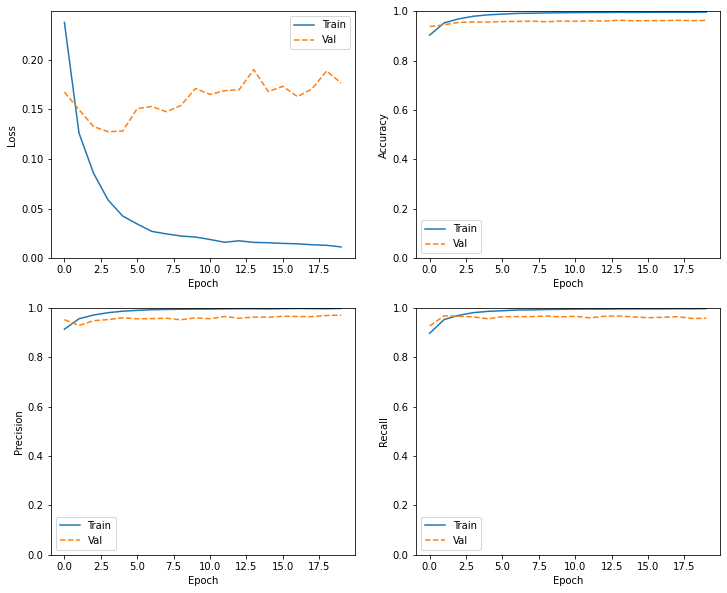

In [22]:
plot_metrics(history)

In [23]:
y_probas_train_tfidf = model.predict(x_train_tfidf)
y_probas_test_tfidf = model.predict(x_test_tfidf)

In [24]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf) 

True Negatives:  3614
False Positives:  96
False Negatives:  153
True Positives:  3736


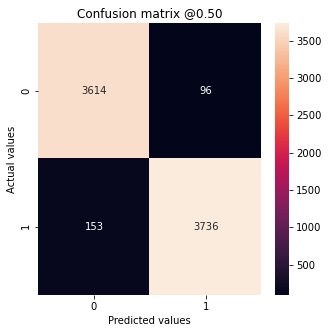

In [25]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [26]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3710
           1       0.97      0.96      0.97      3889

    accuracy                           0.97      7599
   macro avg       0.97      0.97      0.97      7599
weighted avg       0.97      0.97      0.97      7599



In [27]:
f1 = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1)

F1: 0.97


In [28]:
auc = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc)

AUC: 0.99


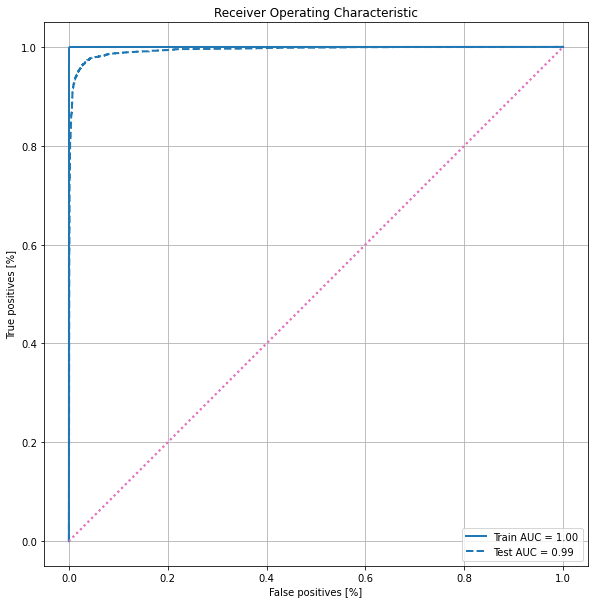

In [29]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

***
**AdaGrad**
***

In [30]:
model = make_model(optimizer = 'adagrad')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 24996, 16)         96        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12498, 16)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12494, 16)         1296      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6247, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 99952)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 99952)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [31]:
history = model.fit(x_train_tfidf, 
                        y_train_tfidf, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val_tfidf, y_val_tfidf))

Epoch 1/20
855/855 [==============================] - 1600s 2s/step - loss: 0.6930 - tp: 18540.6612 - fp: 11299.4042 - tn: 8808.5257 - fn: 2452.3014 - accuracy: 0.6958 - precision: 0.6591 - recall: 0.8829 - auc: 0.7917 - val_loss: 0.6923 - val_tp: 7000.0000 - val_fp: 6677.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5118 - val_precision: 0.5118 - val_recall: 1.0000 - val_auc: 0.6071
Epoch 2/20
855/855 [==============================] - 1555s 2s/step - loss: 0.6922 - tp: 13981.9509 - fp: 13219.1636 - tn: 138.8505 - fn: 83.9276 - accuracy: 0.5150 - precision: 0.5139 - recall: 0.9938 - auc: 0.5511 - val_loss: 0.6916 - val_tp: 7000.0000 - val_fp: 6677.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5118 - val_precision: 0.5118 - val_recall: 1.0000 - val_auc: 0.7402
Epoch 3/20
855/855 [==============================] - 3401s 4s/step - loss: 0.6916 - tp: 13950.8621 - fp: 13145.8773 - tn: 233.5070 - fn: 93.6460 - accuracy: 0.5172 - precision: 0.5150 - reca

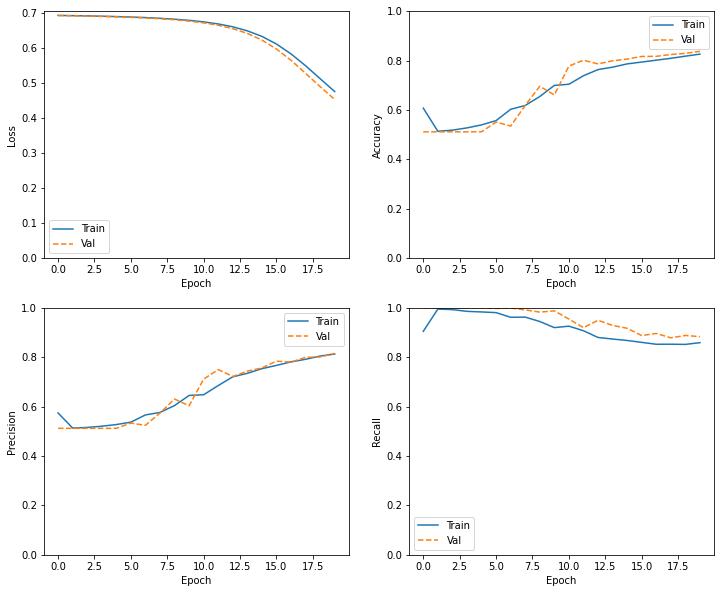

In [32]:
plot_metrics(history)

In [33]:
y_probas_train_tfidf = model.predict(x_train_tfidf)
y_probas_test_tfidf = model.predict(x_test_tfidf)

In [34]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf) 

True Negatives:  2957
False Positives:  753
False Negatives:  457
True Positives:  3432


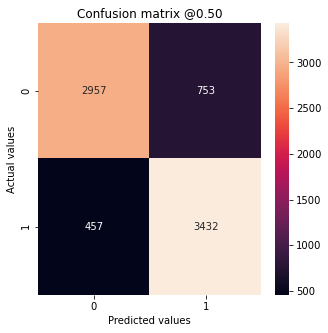

In [35]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [36]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3710
           1       0.82      0.88      0.85      3889

    accuracy                           0.84      7599
   macro avg       0.84      0.84      0.84      7599
weighted avg       0.84      0.84      0.84      7599



In [37]:
f1 = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1)

F1: 0.84


In [38]:
auc = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc)

AUC: 0.92


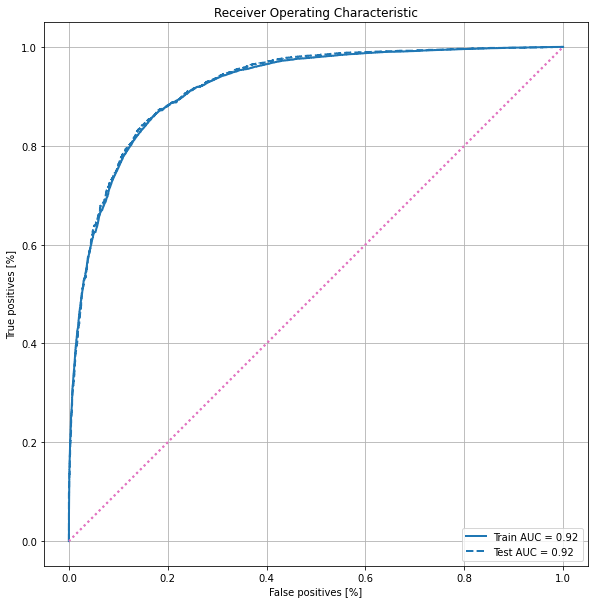

In [39]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

***
**RMSProp**
***

In [40]:
model = make_model(optimizer = 'rmsprop')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 24996, 16)         96        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12498, 16)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 12494, 16)         1296      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 6247, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 99952)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 99952)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [41]:
history = model.fit(x_train_tfidf, 
                        y_train_tfidf, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val_tfidf, y_val_tfidf))

Epoch 1/20
855/855 [==============================] - 1289s 2s/step - loss: 0.3579 - tp: 18197.4381 - fp: 3036.7021 - tn: 17048.2932 - fn: 2818.4591 - accuracy: 0.8490 - precision: 0.8472 - recall: 0.8602 - auc: 0.9226 - val_loss: 0.1946 - val_tp: 6624.0000 - val_fp: 622.0000 - val_tn: 6055.0000 - val_fn: 376.0000 - val_accuracy: 0.9270 - val_precision: 0.9142 - val_recall: 0.9463 - val_auc: 0.9770
Epoch 2/20
855/855 [==============================] - 1256s 1s/step - loss: 0.1708 - tp: 13109.2009 - fp: 842.6215 - tn: 12558.5759 - fn: 913.4942 - accuracy: 0.9365 - precision: 0.9399 - recall: 0.9357 - auc: 0.9813 - val_loss: 0.1668 - val_tp: 6603.0000 - val_fp: 418.0000 - val_tn: 6259.0000 - val_fn: 397.0000 - val_accuracy: 0.9404 - val_precision: 0.9405 - val_recall: 0.9433 - val_auc: 0.9822
Epoch 3/20
855/855 [==============================] - 1261s 1s/step - loss: 0.1461 - tp: 13346.0537 - fp: 680.6647 - tn: 12657.5689 - fn: 739.6051 - accuracy: 0.9482 - precision: 0.9516 - recall: 0.

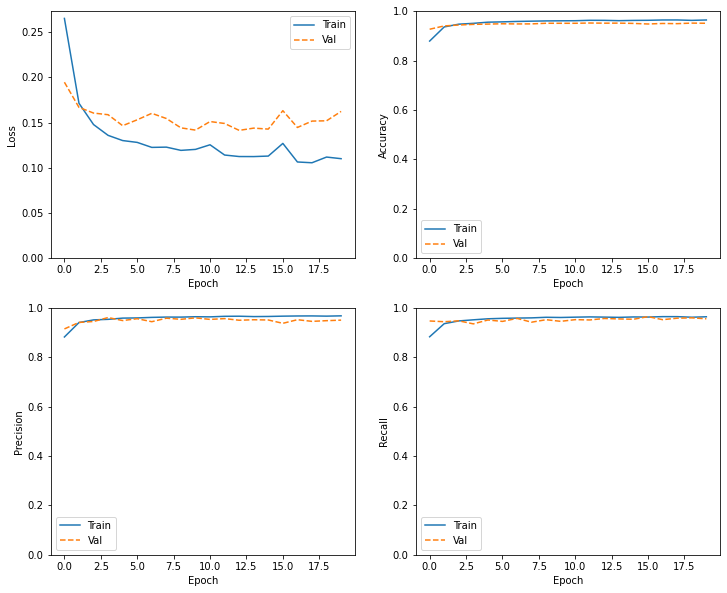

In [42]:
plot_metrics(history)

In [43]:
y_probas_train_tfidf = model.predict(x_train_tfidf)
y_probas_test_tfidf = model.predict(x_test_tfidf)

In [44]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf) 

True Negatives:  3536
False Positives:  174
False Negatives:  154
True Positives:  3735


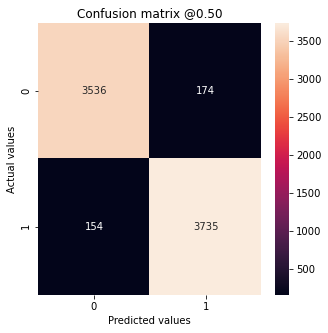

In [45]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [46]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3710
           1       0.96      0.96      0.96      3889

    accuracy                           0.96      7599
   macro avg       0.96      0.96      0.96      7599
weighted avg       0.96      0.96      0.96      7599



In [47]:
f1 = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1)

F1: 0.96


In [48]:
auc = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc)

AUC: 0.99


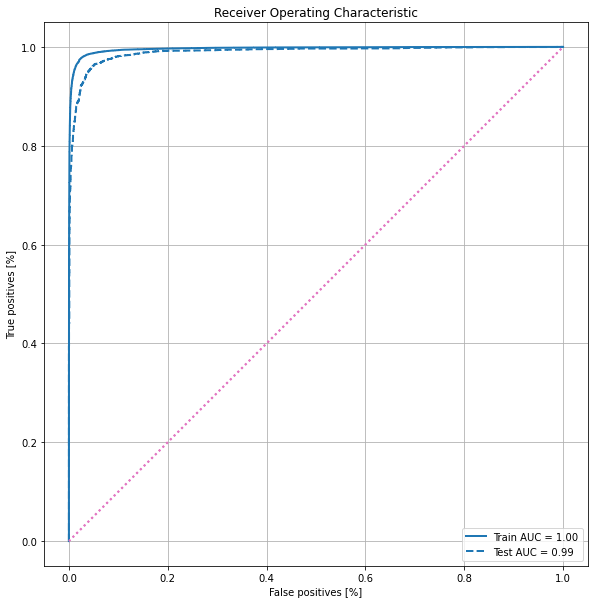

In [49]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

***
**AdaDelta**
***

In [50]:
model = make_model(optimizer = 'adadelta')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 24996, 16)         96        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 12498, 16)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 12494, 16)         1296      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 6247, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 99952)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 99952)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [51]:
history = model.fit(x_train_tfidf, 
                        y_train_tfidf, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val_tfidf, y_val_tfidf))

Epoch 1/20
855/855 [==============================] - 666s 777ms/step - loss: 0.6931 - tp: 13188.0386 - fp: 6476.6542 - tn: 13573.7138 - fn: 7862.4860 - accuracy: 0.6817 - precision: 0.7017 - recall: 0.6568 - auc: 0.7789 - val_loss: 0.6931 - val_tp: 4590.0000 - val_fp: 3982.0000 - val_tn: 2695.0000 - val_fn: 2410.0000 - val_accuracy: 0.5326 - val_precision: 0.5355 - val_recall: 0.6557 - val_auc: 0.5000
Epoch 2/20
855/855 [==============================] - 667s 780ms/step - loss: 0.6931 - tp: 8157.6157 - fp: 7237.8119 - tn: 6162.6963 - fn: 5865.7687 - accuracy: 0.5212 - precision: 0.5305 - recall: 0.5737 - auc: 0.5005 - val_loss: 0.6930 - val_tp: 6080.0000 - val_fp: 5129.0000 - val_tn: 1548.0000 - val_fn: 920.0000 - val_accuracy: 0.5577 - val_precision: 0.5424 - val_recall: 0.8686 - val_auc: 0.5000
Epoch 3/20
855/855 [==============================] - 678s 793ms/step - loss: 0.6930 - tp: 9739.8528 - fp: 8515.2792 - tn: 4863.6554 - fn: 4305.1051 - accuracy: 0.5312 - precision: 0.5327 - r

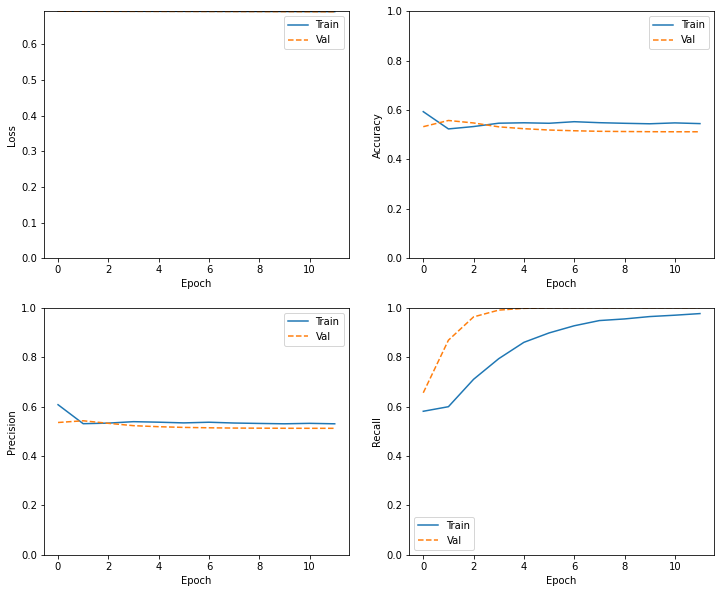

In [52]:
plot_metrics(history)

In [53]:
y_probas_train_tfidf = model.predict(x_train_tfidf)
y_probas_test_tfidf = model.predict(x_test_tfidf)

In [54]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf) 

True Negatives:  911
False Positives:  2799
False Negatives:  580
True Positives:  3309


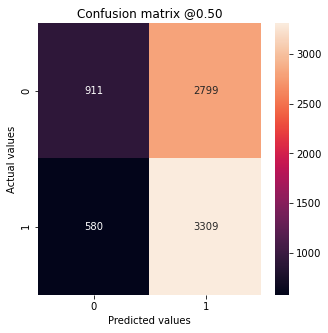

In [55]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [56]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.61      0.25      0.35      3710
           1       0.54      0.85      0.66      3889

    accuracy                           0.56      7599
   macro avg       0.58      0.55      0.51      7599
weighted avg       0.58      0.56      0.51      7599



In [57]:
f1 = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1)

F1: 0.51


In [58]:
auc = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc)

AUC: 0.60


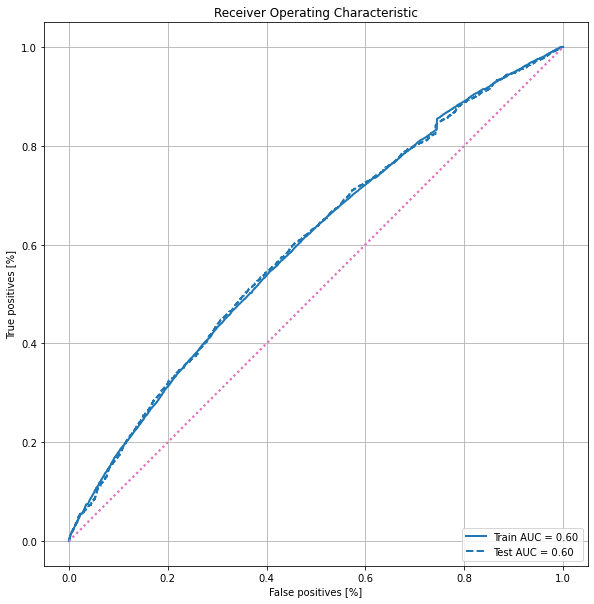

In [59]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

***
**SGD**
***

In [60]:
model = make_model(optimizer = 'sgd')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 24996, 16)         96        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 12498, 16)         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 12494, 16)         1296      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 6247, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 99952)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 99952)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [61]:
history = model.fit(x_train_tfidf, 
                        y_train_tfidf, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val_tfidf, y_val_tfidf))

Epoch 1/20
855/855 [==============================] - 1243s 1s/step - loss: 0.6927 - tp: 19070.1250 - fp: 18109.7897 - tn: 1941.4171 - fn: 1979.5607 - accuracy: 0.5106 - precision: 0.5126 - recall: 0.8948 - auc: 0.5714 - val_loss: 0.6907 - val_tp: 7000.0000 - val_fp: 6677.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5118 - val_precision: 0.5118 - val_recall: 1.0000 - val_auc: 0.6795
Epoch 2/20
855/855 [==============================] - 1118s 1s/step - loss: 0.6898 - tp: 13391.8879 - fp: 11954.5701 - tn: 1391.2407 - fn: 686.1939 - accuracy: 0.5350 - precision: 0.5264 - recall: 0.9619 - auc: 0.6066 - val_loss: 0.6859 - val_tp: 6958.0000 - val_fp: 5462.0000 - val_tn: 1215.0000 - val_fn: 42.0000 - val_accuracy: 0.5976 - val_precision: 0.5602 - val_recall: 0.9940 - val_auc: 0.8618
Epoch 3/20
855/855 [==============================] - 1225s 1s/step - loss: 0.6845 - tp: 12945.2033 - fp: 9727.9696 - tn: 3657.6904 - fn: 1093.0292 - accuracy: 0.6024 - precision: 0.5691 - reca

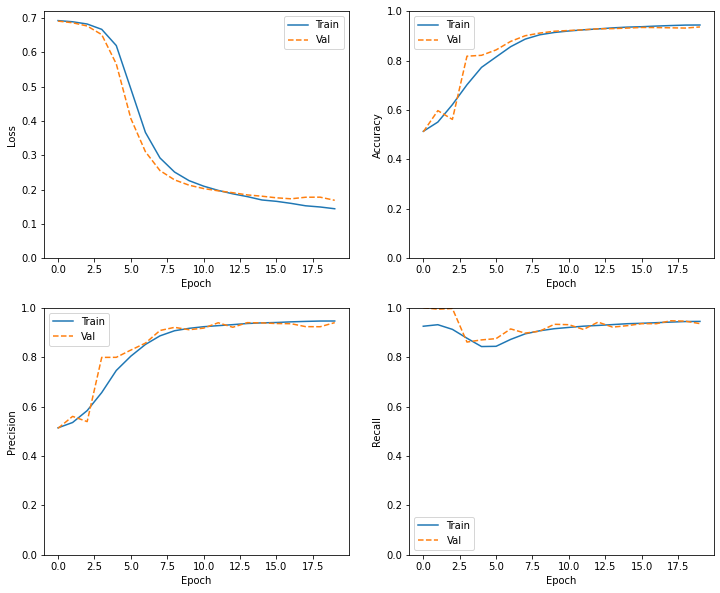

In [62]:
plot_metrics(history)

In [63]:
y_probas_train_tfidf = model.predict(x_train_tfidf)
y_probas_test_tfidf = model.predict(x_test_tfidf)

In [64]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf) 

True Negatives:  3478
False Positives:  232
False Negatives:  227
True Positives:  3662


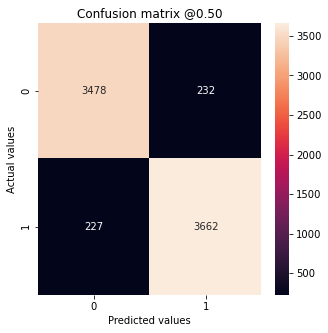

In [65]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [66]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3710
           1       0.94      0.94      0.94      3889

    accuracy                           0.94      7599
   macro avg       0.94      0.94      0.94      7599
weighted avg       0.94      0.94      0.94      7599



In [67]:
f1 = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1)

F1: 0.94


In [68]:
auc = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc)

AUC: 0.98


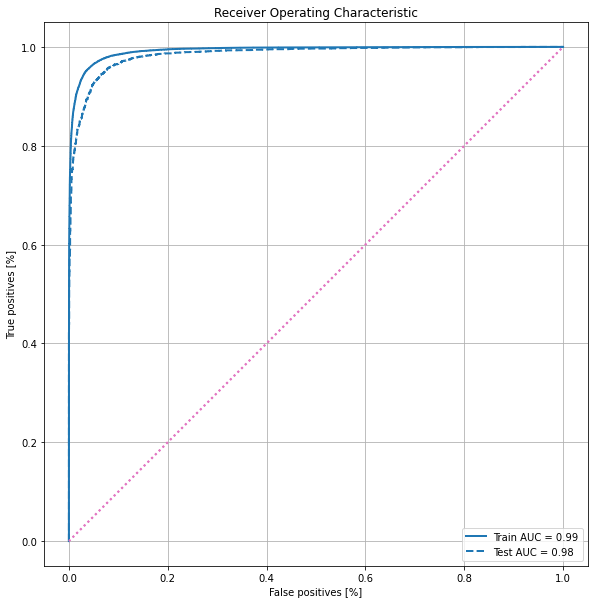

In [69]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')